In [1]:
"""
This script runs a gridsearch and saves the results to a CSV file. This can be used on SLURM
"""

import os
import sys
try:
    task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])-1 # index starts from 1!
    n_tasks = int(os.environ['SLURM_ARRAY_TASK_COUNT'])
except Exception as err:
    print(err)
    task_id = 0
    n_tasks = 1   


TEMP_SAVE= f'sweet_spot_low2.pkl' #MP


try:
    import nqcpfem
except ModuleNotFoundError:
    import sys
    sys.path.extend([r'/mnt/c/Users/olisc/NQCP/NQCP_FEM/'])
    import nqcpfem
import pandas as pd
import logging
LOGGER = logging.getLogger()

LOGGER.setLevel(logging.DEBUG)

file_formatting =logging.Formatter(fmt='- %(asctime)s: %(processName)s:%(name)s >> %(levelname)s:%(message)s', datefmt= '%Y-%m-%d %H:%M:%S')
if True:
    ch= logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    ch.setFormatter(file_formatting)
    #LOGGER.addHandler(ch)

import numpy as np
import sympy
E0 = 1/(nqcpfem.UNIT_CONVENTION['J to eV']*1000000) # unit_scale: 1muev
from nqcpfem.solvers import PETScSolver
from nqcpfem.systems import PositionalState,DefiniteTensorComponent
from nqcpfem.envelope_function import RectangleDomain
from nqcpfem.fenics import FEniCsModel
from nqcpfem.band_model import LuttingerKohnHamiltonian
from nqcpfem.systems.dot_sc_dot import *



def syst_init(B=1.75,aspect_ratio=1):
    H = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge').add_z_confinement(1,'box',25e-9)
    H.BdG_extension()
    #B = 1.75
    H.add_zeeman_term(B=[B/np.sqrt(2),B/np.sqrt(2),0])
    

    #H.add_potential(-sympy.symbols('\mu'))

    domain =RectangleDomain(200e-9,100e-9,0)
    domain.resolution = [100,50]
    from nqcpfem import _hbar,_m_e
    model = FEniCsModel(H,None, boundary_condition=0,function_class=('CG',1))
    omega = 2e12 # chosen so that short side of dot is around 50 nm  
    omega = 5e11 # old code?
    print(omega)
    L_sc = 300e-9
    D_dot = 70e-9
    ldot = Dot(-(D_dot/2 +1e-9+L_sc/2),omega,0,D_dot,aspect_ratio*omega,0,100e-9,)
    rdot = Dot(( D_dot/np.sqrt(aspect_ratio)/2+ 1e-9+L_sc/2),aspect_ratio*omega,0,D_dot/np.sqrt(aspect_ratio),omega,0,100e-9,)
    barr = Barrier(0e-9,1000*E0) # 1 meV barrier
    barr = Barrier(0e-9,1000*E0) # 1 meV barrier
    
    ldot = Dot(-(86e-9+L_sc/2),omega,0,150e-9,aspect_ratio*omega,0,150e-9,)
    rdot = Dot((86e-9+L_sc/2),aspect_ratio*omega,0,150e-9,omega,0,150e-9,)
    barr = Barrier(10e-9,1000*E0) # 1 meV barrier
    #rbarr = Barrier(15e-9,3/(nqcpfem.UNIT_CONVENTION['J to eV']*1000))
    sc = Superconductor(100*E0,L_sc,100e-9,0,5*E0)
    syst = DotSCDot(model,ldot,barr,sc,barr,rdot,domain_resolution=[125,50])

    mu,mu_sc = sympy.symbols('\mu,\mu_{sc}')
    mu_R = sympy.symbols('\mu_{R}')
    mu_L = sympy.symbols('\mu_{L}')
    chemical_potential = SymbolicFunction(sympy.Piecewise((-mu_sc,syst.domains['sc_in']),(-mu_L,syst.domains['ld_in']),(-mu_R,syst.domains['rd_in']),(0,True)),'\mu(x)')
    H.add_potential(chemical_potential)

    H.parameter_dict[mu_L] = 0*E0 # will be set to something other than zero on determining couping
    H.parameter_dict[mu_R] = 0*E0 # will be set to something other than zero on determining couping
    H.parameter_dict[mu_sc] = 0

    #minimizations = syst.determine_all_couplings(0,3,solver,425*E0,(-50*E0,50*E0))
    return syst

#syst = syst_init(2) # initialize before to get easier access.

from nqcpfem.solvers import PETScSolver,IterativeSolver
solver = PETScSolver(k=16,which='SM',sigma=0)

def system_update(mu_sc_val,mL,mR,syst=None):
    mu_R = sympy.symbols('\mu_{R}')
    mu,mu_sc = sympy.symbols('\mu,\mu_{sc}')
    mu_L = sympy.symbols('\mu_{L}')
    syst.envelope_model.band_model.parameter_dict[mu_L] = mL
    syst.envelope_model.band_model.parameter_dict[mu_R] = mR
    syst.envelope_model.band_model.parameter_dict[mu_sc] = mu_sc_val
    return syst.envelope_model

first_solver = PETScSolver(k=8,sigma=0,which='SM')
second_solver = PETScSolver(k=8,sigma=0,which='SM',method='GD') # GD uses the the entire subspaces of the previous guess!
second_solver =None
solver = IterativeSolver(first_solver,second_solver)

from nqcpfem.band_model import covariant_sorting
from nqcpfem.majorana import majorana_overlap
def eval_func(model,res):

    try:
        #l_dot,r_dot,sc = syst.__make_system_classes__()
        #X_points = syst.envelope_model.positional_rep(res[1][0])[1]
        #selection=syst.select_subspace((l_dot,r_dot),res[1],4,x_points=X_points) # discard the states in the superconductor as we do not care about them
        
        overlaps = [majorana_overlap(res[1][i],model) for i in range(len(res[0]))]
        
        return res[0],overlaps
    except Exception as err:
        print(err)
        LOGGER.exception(err)
        LOGGER.info(err)
        raise err
        return res[0],None


from nqcpfem.parameter_search import IterativeModelSolver
it_solver = IterativeModelSolver(system_update,solver,eval_func)




if __name__ == '__main__':
    
    # construct parameter set for this worker
    mu_sc_values = np.linspace(3e3,9e3,16)[::4]*E0 
    #mu_sc_values = np.linspace(9.8e3,10.2e3,9)*E0
    #mu_sc_values = np.linspace(9.9e3,10.6e3,16)*E0
    #mu_sc_values = [9.5e3*E0,10e3*E0,10.5e3*E0]
    #mu_sc_values = np.linspace(4200,5200,8)*E0#+list(np.linspace(5700,6200,8)*E0)
    E0_values = np.linspace(4000,4120,1)*E0
    E0_values = [4120*E0,4150*E0]
    
    
    #high mu sweet spot
    mu_sc_values = np.linspace(6100,6200,8)*E0 # High mu sweet_spot zoom
    mR_values = np.linspace(4602.75,4604.5,48)*E0 #+list(np.linspace(4512,4614,48)*E0)
    mL_values = np.linspace(4597.5,4601,64)*E0
    
    # low mu sweet spot
    mu_sc_values = np.linspace(4382,4425,8)*E0 # Log mu sweet_spot zoom
    mR_values = np.linspace(4603.6,4604.4,32)*E0 #+list(np.linspace(4512,4614,48)*E0)
    mL_values = np.linspace(4598.4,4600,64)*E0
    
    parameter_set = [{'mu_sc_val':mu_val,'mL':ml,'mR':mr} for  mu_val in mu_sc_values for mr in mR_values for ml in mL_values]





'SLURM_ARRAY_TASK_ID'


In [3]:
from nqcpfem import _m_e,_hbar
omega = _hbar/(2*_m_e * (0.5*50e-9)**2)/1.44 # chosen so that short side of dot is around 50 nm in total size
print(f"{omega:.2E}")

6.43E+10


In [3]:
S = system_update(7.040422e-22,4600*E0-270*E0,4600*E0-300*E0,syst=syst_init(B=2,aspect_ratio=1))
SOL = solver.solve(S)

500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_40f8f50e07de3d26df42cbff3da565616b5839fe' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_40f8f50e07de3d26df42cbff3da565616b5839fe.c

(51408, 51408)


In [17]:
7.040422e-22/E0
7.367972e-22/E0

4598.726409837282

In [77]:
funcs = list(S.band_model.function_dict.keys()) 
print(S.band_model.function_dict[funcs[3]].expression)

Piecewise((9.4446090217152e-9*y**2 + 4.55469185075e-9*(x + 2.31e-7)**2, (x >= -3.06e-7) & (y >= -7.5e-8) & (x <= -1.56e-7) & (y <= 7.5e-8)), (4.55469185075e-9*y**2 + 9.4446090217152e-9*(x - 2.31e-7)**2, (x >= 1.56e-7) & (y >= -7.5e-8) & (x <= 3.06e-7) & (y <= 7.5e-8)), (7.87460674076167e-23, (x <= -1.55e-7) & ~((x >= -3.06e-7) & (y >= -7.5e-8) & (x <= -1.56e-7) & (y <= 7.5e-8))), (7.87460674076168e-23, (x >= 1.55e-7) & ~((x >= 1.56e-7) & (y >= -7.5e-8) & (x <= 3.06e-7) & (y <= 7.5e-8))), (1.602176634e-22, ((x >= 1.45e-7) | (x <= -1.45e-7)) & ((x >= 1.45e-7) | (x > -1.55e-7)) & ((x <= -1.45e-7) | (x < 1.55e-7)) & ((x > -1.55e-7) | (x < 1.55e-7))), (0, (x >= -1.45e-7) & (y >= -5.0e-8) & (x <= 1.45e-7) & (y <= 5.0e-8)), (8.01088317e-25, (x >= -1.45e-7) & (x <= 1.45e-7) & ~((y >= -5.0e-8) & (y <= 5.0e-8))))


In [9]:
print(SOL[0]/E0)

[ 100.11455014 -100.11455014  141.20582952 -141.20582952  173.86503311
 -173.86503311 -271.80488427  271.80488427 -275.46247536  275.46247536]


In [14]:
import pickle as pkl
# save the wave-functions and the potential:
with open('wave_funcs_SWEET.pkl','wb') as f:
    pkl.dump(SOL[1][:2],f)

grid = S.mesh().geometry.x
with open('geometry_SWEET.pkl','wb') as f:
    pkl.dump(grid,f)

with open('potential_SWEET.pkl','wb') as f:
    V = syst.__make_EM_potential__(nqcpfem._m_e)
    V_interp=V(grid.T*S.length_scale())/(1000*E0) # potential in meV
    pkl.dump(V_interp,f)
    

#save the VTK mesh as well for plotting wave-function and grid in ParaView:


In [152]:
import dolfinx.io
from dolfinx.plot import create_vtk_mesh
from mpi4py import MPI

from pathlib import Path
from nqcpfem.fenics import FEniCsModel
func_space = FEniCsModel.__make_function_space__(S.mesh(),('CG',1),(1,))

def wave_func_post_process(v):
    v_norm = np.linalg.norm(v,axis=0)**2
    v_norm = v_norm[0]
    print(np.max(v_norm))
    return v_norm
# save the norm of th
up = dolfinx.fem.Function(func_space)
up.x.array[:] = wave_func_post_process(SOL[1][0])
up.name = "particle_gs"

uh = dolfinx.fem.Function(func_space)
uh.x.array[:] = wave_func_post_process(SOL[1][1])
uh.name = "hole_gs"

results_folder = Path("results")
results_folder.mkdir(exist_ok=True, parents=True)
with dolfinx.io.VTXWriter(MPI.COMM_WORLD, results_folder / "particle.bp", [uh],) as vtx: #engine="BP4") as vtx:
    vtx.write(0.0)
with dolfinx.io.VTXWriter(MPI.COMM_WORLD, results_folder / "hole.bp", [up],)as vtx: # engine="BP4") as vtx:
    vtx.write(0.0)

with dolfinx.io.VTXWriter(MPI.COMM_WORLD, results_folder / "hole.bp", [up],)as vtx: # engine="BP4") as vtx:
    vtx.write(0.0)


82.63489268192325
82.6348922712135


In [153]:
mesh = S.mesh()
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_function(uh)
    xdmf.write_function(up)
    #xdmf.write_meshtags(ct, mesh.geometry)

In [ ]:
V_norm

In [147]:
print(SOL[1][0].shape)
print(SOL[0])

(8, 1, 25351)


In [14]:
#4598.8
print(SOL[0]/E0)

[  56.07499248  -56.07499248   56.53636839  -56.53636839   78.65821339
  -78.65821339   79.27465028  -79.27465028   92.45914488  -92.45914488
  127.92228333 -127.92228333]


In [7]:
def P_trans(s):
    return np.einsum('ij,j...->i...',U,np.conj(s))

In [8]:
from importlib import reload    
majo = reload(nqcpfem.majorana)

In [10]:
R=majo.super_majorana_overlap(SOL[1][0],SOL[1][1],S)

2.3258002873425387
3.9573850198370466
1.3174254671355283
3.023928072350433
3.0869688735494667
3.0852251318316775
3.083721941666909
3.0837253207392306


- 2023-10-27 08:46:19: MainProcess:nqcpfem.majorana >> DEBUG: message: Solution found.
 success: True
  status: 0
     fun: -0.9964525931453333
       x: 3.083721941666909
     nit: 9
    nfev: 9


3.0837185625945875


In [53]:
R

(0.01689863251317421, 3.101458617522687)

In [11]:
from nqcpfem.majorana import majorana_overlap_bound


majorana_overlap_bound(SOL[1][0],SOL[1][1],S)

(0.9964526260023596+0j)

In [12]:
f = SOL[1][0]
f=f/np.linalg.norm(f)
g = SOL[1][1]
g=g/np.linalg.norm(g)


def gauge_theta(theta):
    psi_p = 1/np.sqrt(2)*(np.exp(1j*theta)*f+np.exp(-1j*theta)*g).reshape(8,-1)
    psi_m= 1/np.sqrt(2)*(np.exp(1j*theta)*f-np.exp(-1j*theta)*g).reshape(8,-1)
    return psi_p,psi_m



In [1]:
R

NameError: name 'R' is not defined

In [17]:
from importlib import reload
from nqcpfem import plotting
plot = reload(nqcpfem.plotting)

- 2023-10-27 08:51:14: MainProcess:matplotlib >> DEBUG:matplotlib data path: /home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/mpl-data
- 2023-10-27 08:51:14: MainProcess:matplotlib >> DEBUG:CONFIGDIR=/home/oliver/.config/matplotlib
- 2023-10-27 08:51:14: MainProcess:matplotlib >> DEBUG:interactive is False
- 2023-10-27 08:51:14: MainProcess:matplotlib >> DEBUG:platform is linux
- 2023-10-27 08:51:15: MainProcess:matplotlib >> DEBUG:CACHEDIR=/home/oliver/.cache/matplotlib
- 2023-10-27 08:51:15: MainProcess:matplotlib.font_manager >> DEBUG:Using fontManager instance from /home/oliver/.cache/matplotlib/fontlist-v330.json


In [15]:
modulus=np.abs(np.einsum('ijl,ijl->l',f,g.conj()))
phase=np.angle(np.einsum('ijl,ijl->l',f,g.conj()))

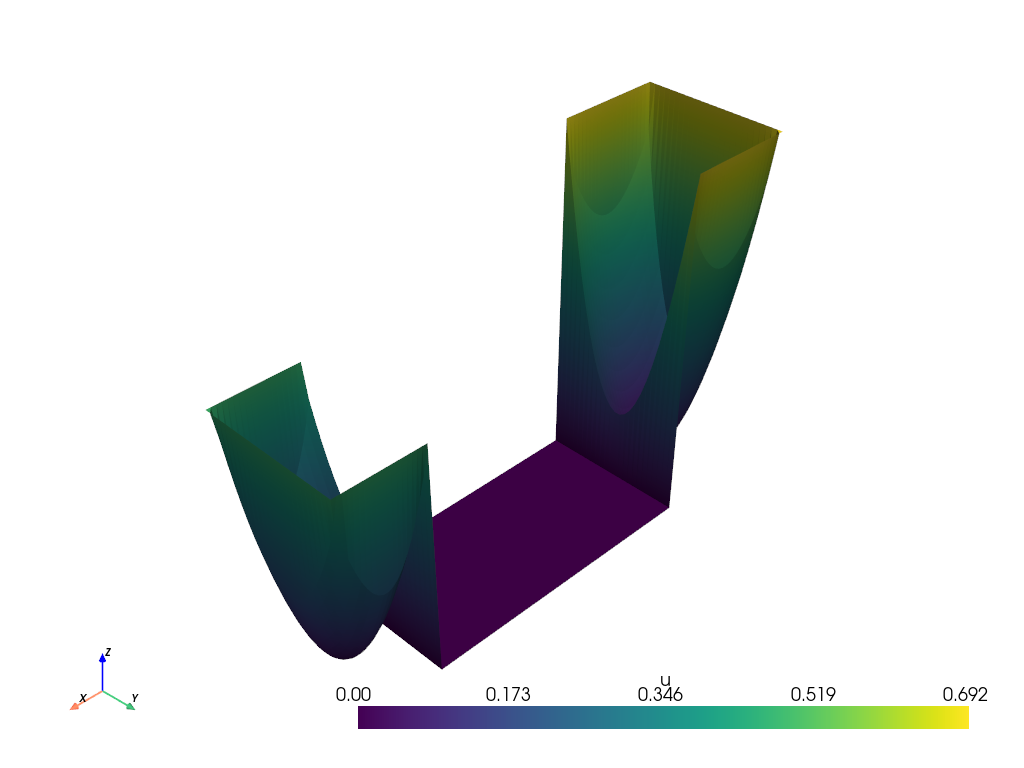

In [211]:
import pyvista
pyvista.set_jupyter_backend('static')
#_f = pdf_m
#_f = modulus
#_f  =_f/np.linalg.norm(_f)
#_f = _f**0.3
#_f = _f*10/np.linalg.norm(_f)



grid = S.mesh().geometry.x
V = syst.__make_EM_potential__(nqcpfem._m_e)
V_interp=V(grid.T*S.length_scale())/(1000*E0) # potential in meV
from nqcpfem.plotting import plot_interpolated_scalar
plot_interpolated_scalar(V_interp*10/np.linalg.norm(V_interp),S,)

DEBUG:matplotlib:matplotlib data path: /home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/oliver/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:CACHEDIR=/home/oliver/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/oliver/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='n

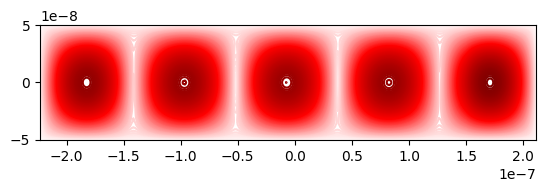

In [6]:
from matplotlib import pyplot as plt
import matplotlib as mpl

def plot_map(val,title=None,norm=None,cmap='seismic',fig_ax=None,nlevels=128):
    if norm is None:
        c_range = np.max(np.abs(val))
        norm = mpl.colors.Normalize(-c_range,c_range) 
    
    if fig_ax is None:
        fig, ax = plt.subplots()
    else:
        fig,ax = fig_ax
    X = S.mesh().geometry.x*S.length_scale()
    #f=ax.tricontourf(X[:,0],X[:,1],val,levels=nlevels,cmap=cmap,norm=norm)
    f=ax.tricontour(X[:,0],X[:,1],val,levels=nlevels,cmap=cmap,norm=norm)
    ax.set_title(title)
    ax.set_aspect('equal')
    #fig.colorbar(f)
    
plot_map(np.linalg.norm(SOL[1][2][:,0],axis=0))

In [7]:
theta = R[1]
phi_p,phi_m = gauge_theta(theta)
pdf_p  = np.linalg.norm(phi_p,axis=0)**2
pdf_m  = np.linalg.norm(phi_m,axis=0)**2
z=0.5*(pdf_p-pdf_m)
from matplotlib.colors import LogNorm
plot_map(z,title=f"F={np.sum(np.abs(z))}")
from matplotlib.colors import Normalize

plot_map(pdf_p,title=f"F={np.sum(np.abs(z))}",norm=Normalize(np.min(pdf_p),np.max(pdf_p)),cmap='viridis')#norm=LogNorm())
plot_map(pdf_m,title=f"F={np.sum(np.abs(z))}",norm=Normalize(np.min(pdf_m),np.max(pdf_m)),cmap='viridis')#norm=LogNorm())
min_val = -1000
F = np.log(pdf_p)
F[F<min_val] = min_val
G = np.log(pdf_m)
G[G<min_val] = min_val
plot_map(F,title=f"F={np.sum(np.abs(z))}",norm=Normalize(min_val,np.max(F)),cmap='Reds')#norm=LogNorm())
plot_map(G,title=f"F={np.sum(np.abs(z))}",norm=Normalize(min_val,np.max(G)),cmap='Reds')#norm=LogNorm())
    

NameError: name 'R' is not defined

In [56]:
V = syst.__make_EM_potential__(nqcpfem._m_e)

In [59]:
grid = S.mesh().geometry.x[:]

In [71]:
V_interp=V(grid.T*S.length_scale())/(1000*E0) # potential in meV
V = syst.__make_EM_potential__(nqcpfem._m_e)

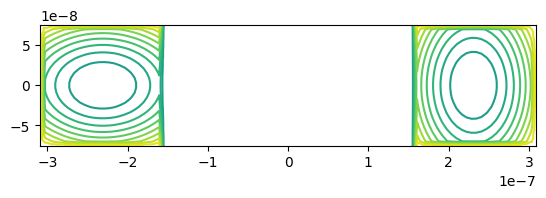

In [127]:
plot_map(V_interp,cmap='viridis',nlevels=10)

AttributeError: 'numpy.float64' object has no attribute 'set_aspect'

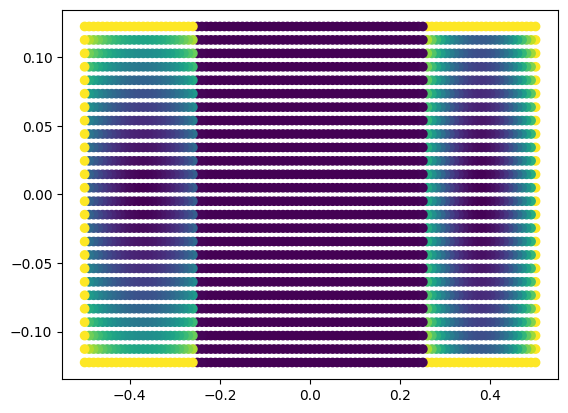

In [110]:
plt.scatter(grid[:,0],grid[:,1],c=V_interp)
plaspect('equal')

In [16]:
SOL[0]/E0

array([  56.07499248,  -56.07499248,   56.53636839,  -56.53636839,
         78.65821339,  -78.65821339,   79.27465028,  -79.27465028,
         92.45914488,  -92.45914488,  127.92228333, -127.92228333])

In [25]:
syst = syst_init(B=2,aspect_ratio=1)
S = system_update(7.040422e-22,4600*E0-270*E0,4600*E0-300*E0,syst=syst)
SOL = solver.solve(S)
print(SOL[0]/E0)

500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_d044da8012c697a56b6bf62915769650fb2cb21a' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_d044da8012c697a56b6bf62915769650fb2cb21a.c

(51408, 51408)


DEBUG:nqcpfem.solvers: number of converged eigenvectors: 10


[  21.24195419  -21.24195419   32.37941061  -32.37941061   50.88642856
  -50.88642856   61.87808486  -61.87808486  104.7894641  -104.7894641 ]


In [44]:
res[0]/E0

array([  95.17197417,  -95.17197417,  121.6659218 , -121.6659218 ,
        141.58395506, -141.58395507,  150.3854453 , -150.3854453 ,
        158.7224667 , -158.7224667 ,  171.20656695, -171.20656695,
       -185.46251717])

In [47]:
np.save('wave_func.npy',res[1])
np.save('energies.npy',res[0])


In [24]:
from nqcpfem.plotting import plot_eigenvector
import pyvista
pyvista.set_jupyter_backend('static')
I =5
_psi = classification[sys.state_classes[0]][2]
plot_eigenvector(_psi,enf)
from nqcpfem.observables import band_angular_momentum,particle_projector
AM = band_angular_momentum(S.band_model)
PH = particle_projector(S.band_model)
from nqcpfem import _hbar
S_expec = AM.mel(SOL[1][I])/(_hbar)
print((S_expec[1]+S_expec[0])/np.sqrt(2))
print(PH.mel(SOL[1][I]))


IndexError: list index out of range

In [61]:
psi = SOL[1][1]
print(np.linalg.norm(psi[0,0,:])/np.linalg.norm(psi[:])*np.sqrt(2))
print(np.linalg.norm(psi[1,0,:])/np.linalg.norm(psi[:])*np.sqrt(2))
print(np.linalg.norm(psi[2,0,:])/np.linalg.norm(psi[:])*np.sqrt(2))
print(np.linalg.norm(psi[3,0,:])/np.linalg.norm(psi[:])*np.sqrt(2))

0.9938544468016693
0.09084646840446828
0.09084646840447051
0.9938544468017289


In [3]:
from nqcpfem import ANGULAR_MOMENTUM as am 
j = am['3/2']

SS = 1/sympy.sqrt(2)*(j[0])*np.sqrt(2)


Sl = np.zeros((8,8,1,1),dtype='complex')
Sl[:4,:4,0,0] = SS
Sl[4:,4:,0,0] = SS

#obs = syst.envelope_model.construct_observable(Sl)

In [51]:
values = []
psi = res[1]
for th in np.linspace(0,2*np.pi,64):
    print(th)
    SS = j[0]*np.cos(th)+j[1]*np.sin(th)
    Sl[:4,:4,0,0] = SS
    Sl[4:,4:,0,0] = -SS
    obs = S.envelope_model.construct_observable(Sl)
    values.append([obs.mel(psi) for psi in res[1]])


0.0
0.09973310011396169
0.19946620022792338
0.2991993003418851
0.39893240045584677
0.49866550056980846
0.5983986006837702
0.6981317007977319
0.7978648009116935
0.8975979010256552
0.9973310011396169
1.0970641012535787
1.1967972013675403
1.296530301481502
1.3962634015954638
1.4959965017094254
1.595729601823387
1.6954627019373487
1.7951958020513104
1.8949289021652722
1.9946620022792338
2.0943951023931957
2.1941282025071573
2.293861302621119
2.3935944027350806
2.4933275028490423
2.593060602963004
2.6927937030769655
2.7925268031909276
2.8922599033048892
2.991993003418851
3.0917261035328125
3.191459203646774
3.291192303760736
3.3909254038746974
3.490658503988659
3.5903916041026207
3.690124704216583
3.7898578043305444
3.889590904444506
3.9893240045584677
4.089057104672429
4.188790204786391
4.288523304900353
4.388256405014315
4.487989505128276
4.587722605242238
4.687455705356199
4.787188805470161
4.886921905584123
4.9866550056980845
5.086388105812047
5.186121205926008
5.28585430603997
5.385587

In [55]:
values

[[-0.07639078076781047,
  -0.07639078076781125,
  -0.08238700957916002,
  -0.08238700957931391,
  -0.12273696104114158,
  -0.12273696104114207,
  -0.09883972330044373,
  -0.0988397233004445,
  -0.11303956773597701,
  -0.11303956773634298,
  -0.13590176867726866,
  -0.13590176867845905,
  -0.07585359330610622],
 [-0.08444410645338409,
  -0.08444410645338474,
  -0.0933681635353274,
  -0.0933681635354813,
  -0.14067178021221016,
  -0.14067178021221047,
  -0.10577288787985517,
  -0.10577288787985697,
  -0.12052479887778807,
  -0.12052479887822494,
  -0.14600393722884109,
  -0.14600393723002297,
  -0.0854326067923238],
 [-0.09165818867088989,
  -0.09165818867089097,
  -0.10342138273483929,
  -0.10342138273499266,
  -0.15720854003203003,
  -0.1572085400320301,
  -0.11165483397901707,
  -0.111654833979019,
  -0.1268122004202692,
  -0.1268122004207742,
  -0.1546550530571614,
  -0.15465505305832636,
  -0.09416255264999948],
 [-0.0979613306301827,
  -0.09796133063018388,
  -0.11244675376869233,


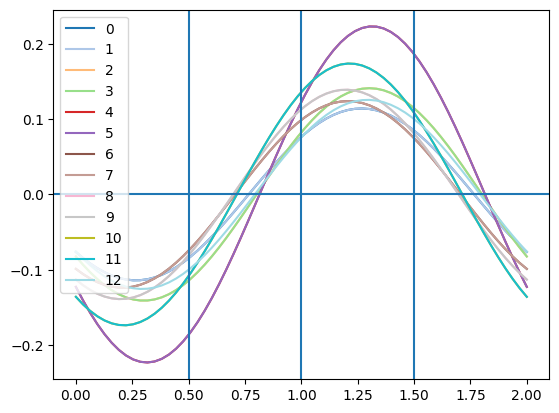

In [61]:
from matplotlib import pyplot as plt 
_v = np.stack(values)
_n =mpl.colors.Normalize()
_n.autoscale(np.arange(13))
for i in range(13):
    cm = mpl.colormaps['tab20']
    norm = mpl.colors.Normalize()
    plt.plot(np.linspace(0,2,64),_v[:,i],label=i, color=cm(_n(i)))
plt.axvline(0.5)
plt.axvline(1)
plt.axvline(1.5)
plt.axhline(0)
plt.legend()

In [63]:
res 

(array([ 1.52482313e-23, -1.52482313e-23,  1.94930297e-23, -1.94930297e-23,
         2.26842505e-23, -2.26842505e-23,  2.40944047e-23, -2.40944047e-23,
         2.54301427e-23, -2.54301427e-23,  2.74303161e-23, -2.74303161e-23,
        -2.97143711e-23]),
 array([[[[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         ...,
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]],
 
 
        [[[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         ...,
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+

In [39]:
S.classify_states()

(array([ 1.52482313e-23, -1.52482313e-23,  1.94930297e-23, -1.94930297e-23,
         2.26842505e-23, -2.26842505e-23,  2.40944047e-23, -2.40944047e-23,
         2.54301427e-23, -2.54301427e-23,  2.74303161e-23, -2.74303161e-23,
        -2.97143711e-23]),
 array([[[[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         ...,
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]],
 
 
        [[[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         ...,
 
         [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j, 0.+

In [4]:
lresults = []
rresults = []
aspects = np.linspace(1,1.6,64)
energy_shifts = np.linspace(0,200,64)
solver = PETScSolver(k=16,which='SM',sigma=0)
for a,e in zip(aspects,energy_shifts):
    S = syst_init(B=2,aspect_ratio=a)
    print(a)
    s = system_update(7.040422e-22,4600*E0-270*E0+e*E0,4600*E0-300*E0+e*E0,syst=S)
    res = solver.solve(s)
    lvalues = []
    rvalues = []
    print(res[0])
    classify = S.classify_states(res[1])
    
    
    for th in np.linspace(0,2*np.pi,64):
        SS = j[0]*np.cos(th)+j[1]*np.sin(th)
        Sl[:4,:4,0,0] = SS
        Sl[4:,4:,0,0] = -SS
        obs = S.envelope_model.construct_observable(Sl)
        lvalues.append([obs.mel(psi) for psi in classify[S.state_classes[0]]])
        rvalues.append([obs.mel(psi) for psi in classify[S.state_classes[1]]])
        
    rresults.append(rvalues)
    lresults.append(lvalues)

500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.0


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_02b76a1abeb86c0561fdca206fba8880b554faa9' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_02b76a1abeb86c0561fdca206fba8880b554faa9.c -o ./libffcx_forms_02b76a1abeb86c0561fdca206fba8880b554faa9.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 3.40333627e-24 -3.40333627e-24  5.18775351e-24 -5.18775351e-24
  8.15290468e-24 -8.15290468e-24  9.91396217e-24 -9.91396217e-24
  1.67891231e-23 -1.67891231e-23  2.26262121e-23 -2.26262121e-23
  2.81662872e-23 -2.81662872e-23  4.94683207e-23 -4.94683207e-23
  4.96479948e-23 -4.96479948e-23  5.89776509e-23 -5.89776509e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.0095238095238095


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_38f3390a7f3ce458d29af668174f3afdd048bdc2' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_38f3390a7f3ce458d29af668174f3afdd048bdc2.c -o ./libffcx_forms_38f3390a7f3ce458d29af668174f3afdd048bdc2.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 2.92291505e-24 -2.92291505e-24  4.70566264e-24 -4.70566264e-24
  7.70043798e-24 -7.70043798e-24  9.46717420e-24 -9.46717420e-24
  1.67356148e-23 -1.67356148e-23  2.26270611e-23 -2.26270611e-23
  2.81484620e-23 -2.81484620e-23  4.94754360e-23 -4.94754360e-23
  4.96488972e-23 -4.96488972e-23  5.90111595e-23 -5.90111595e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.019047619047619


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_b9ac389fe5c41d9001105f743e437815a746232a' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_b9ac389fe5c41d9001105f743e437815a746232a.c -o ./libffcx_forms_b9ac389fe5c41d9001105f743e437815a746232a.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 2.43995903e-24 -2.43995903e-24  4.22185286e-24 -4.22185286e-24
  7.24434320e-24 -7.24434320e-24  9.01865208e-24 -9.01865208e-24
  1.66851779e-23 -1.66851779e-23  2.26279250e-23 -2.26279250e-23
  2.81310237e-23 -2.81310237e-23  4.94824968e-23 -4.94824968e-23
  4.96497975e-23 -4.96497975e-23  5.90443326e-23 -5.90443326e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.0285714285714285


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_b8f611a3dba74d6b444564604fae17867773cab7' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_b8f611a3dba74d6b444564604fae17867773cab7.c -o ./libffcx_forms_b8f611a3dba74d6b444564604fae17867773cab7.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.95454655e-24 -1.95454655e-24  3.73659235e-24 -3.73659235e-24
 -6.78475296e-24  6.78475296e-24  8.56852557e-24 -8.56852557e-24
  1.66375045e-23 -1.66375045e-23  2.26288020e-23 -2.26288020e-23
  2.81139530e-23 -2.81139530e-23  4.94895044e-23 -4.94895044e-23
  4.96506957e-23 -4.96506957e-23  5.90771793e-23 -5.90771793e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.0380952380952382


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_93960dfdc61e92c4142f8c4de351b89608738340' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_93960dfdc61e92c4142f8c4de351b89608738340.c -o ./libffcx_forms_93960dfdc61e92c4142f8c4de351b89608738340.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.46675990e-24 -1.46675990e-24  3.25013013e-24 -3.25013013e-24
 -6.32179608e-24  6.32179608e-24  8.11691385e-24 -8.11691385e-24
  1.65923241e-23 -1.65923241e-23  2.26296909e-23 -2.26296909e-23
  2.80972323e-23 -2.80972323e-23  4.94964595e-23 -4.94964595e-23
  4.96515917e-23 -4.96515917e-23  5.91097082e-23 -5.91097082e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.0476190476190477


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_1ea6feda128ca2e99f7bab3b939e630112342a4e' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_1ea6feda128ca2e99f7bab3b939e630112342a4e.c -o ./libffcx_forms_1ea6feda128ca2e99f7bab3b939e630112342a4e.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 9.76697556e-25 -9.76697556e-25  2.76271018e-24 -2.76271018e-24
 -5.85559792e-24  5.85559792e-24 -7.66392668e-24  7.66392668e-24
  1.65493989e-23 -1.65493989e-23  2.26305903e-23 -2.26305903e-23
  2.80808448e-23 -2.80808448e-23  4.95033634e-23 -4.95033634e-23
  4.96524856e-23 -4.96524856e-23  5.91419276e-23 -5.91419276e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.0571428571428572


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_f44c7beaa18ac800811244c17395d8d2a639158a' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_f44c7beaa18ac800811244c17395d8d2a639158a.c -o ./libffcx_forms_f44c7beaa18ac800811244c17395d8d2a639158a.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 4.84509659e-25 -4.84509659e-25  2.27460841e-24 -2.27460841e-24
 -5.38628083e-24  5.38628083e-24  7.20966553e-24 -7.20966553e-24
  1.65085190e-23 -1.65085190e-23  2.26314991e-23 -2.26314991e-23
  2.80647750e-23 -2.80647750e-23  4.95102168e-23 -4.95102168e-23
  4.96533773e-23 -4.96533773e-23  5.91738454e-23 -5.91738454e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.0666666666666667


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_725602e680592619a633b4814ce4964c14a594e7' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_725602e680592619a633b4814ce4964c14a594e7.c -o ./libffcx_forms_725602e680592619a633b4814ce4964c14a594e7.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 9.45261184e-27 -9.45261184e-27 -1.78628317e-24  1.78628317e-24
  4.91396511e-24 -4.91396511e-24  6.75422488e-24 -6.75422488e-24
  1.64694993e-23 -1.64694993e-23  2.26324162e-23 -2.26324162e-23
  2.80490083e-23 -2.80490083e-23 -4.95170207e-23  4.95170207e-23
 -4.96542667e-23  4.96542667e-23 -5.92054693e-23  5.92054693e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.0761904761904761


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_b14ffb62499e1f0f33c70ddea5bca18046166231' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_b14ffb62499e1f0f33c70ddea5bca18046166231.c -o ./libffcx_forms_b14ffb62499e1f0f33c70ddea5bca18046166231.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 5.03387674e-25 -5.03387674e-25  1.29962544e-24 -1.29962544e-24
  4.43877062e-24 -4.43877062e-24  6.29769397e-24 -6.29769397e-24
  1.64321760e-23 -1.64321760e-23  2.26333408e-23 -2.26333408e-23
  2.80335311e-23 -2.80335311e-23  4.95237760e-23 -4.95237760e-23
  4.96551538e-23 -4.96551538e-23  5.92368068e-23 -5.92368068e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.0857142857142856


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_edbdb714a0d42aa143c3a9b87f6fa84a8626830b' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_edbdb714a0d42aa143c3a9b87f6fa84a8626830b.c -o ./libffcx_forms_edbdb714a0d42aa143c3a9b87f6fa84a8626830b.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 7.84186830e-25 -7.84186830e-25  1.02781531e-24 -1.02781531e-24
  3.96082049e-24 -3.96082049e-24  5.84015945e-24 -5.84015945e-24
  1.63964038e-23 -1.63964038e-23  2.26342720e-23 -2.26342720e-23
  2.80183306e-23 -2.80183306e-23  4.95304835e-23 -4.95304835e-23
  4.96560385e-23 -4.96560385e-23  5.92678651e-23 -5.92678651e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.0952380952380953


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_d5c8d3dd0c9db8a71bab71e79b1c56e42776849e' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_d5c8d3dd0c9db8a71bab71e79b1c56e42776849e.c -o ./libffcx_forms_d5c8d3dd0c9db8a71bab71e79b1c56e42776849e.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 3.09790159e-25 -3.09790159e-25  1.51296207e-24 -1.51296207e-24
  3.48025207e-24 -3.48025207e-24  5.38171091e-24 -5.38171091e-24
  1.63620537e-23 -1.63620537e-23  2.26352090e-23 -2.26352090e-23
  2.80033948e-23 -2.80033948e-23  4.95371441e-23 -4.95371441e-23
  4.96569209e-23 -4.96569209e-23  5.92986511e-23 -5.92986511e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.1047619047619048


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_13ae93b7283dbdcbab6d9190bb050ba73058b39f' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_13ae93b7283dbdcbab6d9190bb050ba73058b39f.c -o ./libffcx_forms_13ae93b7283dbdcbab6d9190bb050ba73058b39f.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.79095494e-25 -1.79095494e-25  2.01434928e-24 -2.01434928e-24
 -2.99727201e-24  2.99727201e-24 -4.92245532e-24  4.92245532e-24
  1.63290109e-23 -1.63290109e-23  2.26361512e-23 -2.26361512e-23
  2.79887127e-23 -2.79887127e-23  4.95437585e-23 -4.95437585e-23
  4.96578009e-23 -4.96578009e-23  5.93291713e-23 -5.93291713e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.1142857142857143


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_3acd28b9f9344fe0da428d76133edc8d956586c2' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_3acd28b9f9344fe0da428d76133edc8d956586c2.c -o ./libffcx_forms_3acd28b9f9344fe0da428d76133edc8d956586c2.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 6.68931386e-25 -6.68931386e-25  2.49958729e-24 -2.49958729e-24
  2.53101160e-24 -2.53101160e-24  4.46257067e-24 -4.46257067e-24
  1.62971731e-23 -1.62971731e-23  2.26370980e-23 -2.26370980e-23
  2.79742736e-23 -2.79742736e-23  4.95503276e-23 -4.95503276e-23
  4.96586785e-23 -4.96586785e-23  5.93594323e-23 -5.93594323e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.1238095238095238


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_2a899d1a5e1f91b79bf900c7754de1f5733c992d' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_2a899d1a5e1f91b79bf900c7754de1f5733c992d.c -o ./libffcx_forms_2a899d1a5e1f91b79bf900c7754de1f5733c992d.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.15822163e-24 -1.15822163e-24  2.02460013e-24 -2.02460013e-24
  3.02500388e-24 -3.02500388e-24  4.00266455e-24 -4.00266455e-24
  1.62664491e-23 -1.62664491e-23  2.26380487e-23 -2.26380487e-23
  2.79600677e-23 -2.79600677e-23  4.95568521e-23 -4.95568521e-23
  4.96595536e-23 -4.96595536e-23  5.93894403e-23 -5.93894403e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.1333333333333333


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_82a03bc85e46257a740e84b3a9c6ed9120807685' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_82a03bc85e46257a740e84b3a9c6ed9120807685.c -o ./libffcx_forms_82a03bc85e46257a740e84b3a9c6ed9120807685.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.51686229e-24 -1.51686229e-24  1.66635182e-24 -1.66635182e-24
  3.49174577e-24 -3.49174577e-24  3.58310493e-24 -3.58310493e-24
  1.62367572e-23 -1.62367572e-23  2.26390029e-23 -2.26390029e-23
  2.79460859e-23 -2.79460859e-23  4.95633328e-23 -4.95633328e-23
  4.96604263e-23 -4.96604263e-23  5.94192013e-23 -5.94192013e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.1428571428571428


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_b80c1f4fccc28573f971e8cc2703983f41601ba2' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_b80c1f4fccc28573f971e8cc2703983f41601ba2.c -o ./libffcx_forms_b80c1f4fccc28573f971e8cc2703983f41601ba2.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-1.03782198e-24  1.03782198e-24  2.14339923e-24 -2.14339923e-24
 -3.07482420e-24  3.07482420e-24  4.04877549e-24 -4.04877549e-24
  1.62080245e-23 -1.62080245e-23  2.26399602e-23 -2.26399602e-23
  2.79323194e-23 -2.79323194e-23  4.95697703e-23 -4.95697703e-23
  4.96612964e-23 -4.96612964e-23  5.94487211e-23 -5.94487211e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.1523809523809523


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_abbc06d2fd17d449b299488d7332f6263bef1855' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_abbc06d2fd17d449b299488d7332f6263bef1855.c -o ./libffcx_forms_abbc06d2fd17d449b299488d7332f6263bef1855.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-5.44414522e-25  5.44414522e-25 -2.59709943e-24  2.59709943e-24
  2.64921932e-24 -2.64921932e-24  4.56021121e-24 -4.56021121e-24
  1.61801857e-23 -1.61801857e-23  2.26409200e-23 -2.26409200e-23
 -2.79187603e-23  2.79187603e-23  4.95761653e-23 -4.95761653e-23
  4.96621641e-23 -4.96621641e-23  5.94780053e-23 -5.94780053e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.161904761904762


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_bb0ecbeb3852ef22167a0f5e46065838a6fd7f8b' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_bb0ecbeb3852ef22167a0f5e46065838a6fd7f8b.c -o ./libffcx_forms_bb0ecbeb3852ef22167a0f5e46065838a6fd7f8b.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-4.89409303e-26  4.89409303e-26 -2.14957143e-24  2.14957143e-24
  3.12445155e-24 -3.12445155e-24  5.07406938e-24 -5.07406938e-24
  1.61531826e-23 -1.61531826e-23  2.26418821e-23 -2.26418821e-23
  2.79054009e-23 -2.79054009e-23  4.95825186e-23 -4.95825186e-23
  4.96630292e-23 -4.96630292e-23  5.95070592e-23 -5.95070592e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.1714285714285715


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_a79e45eccef44c4012286b00c7356d8c5972320d' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_a79e45eccef44c4012286b00c7356d8c5972320d.c -o ./libffcx_forms_a79e45eccef44c4012286b00c7356d8c5972320d.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 4.46869164e-25 -4.46869164e-25  1.68843170e-24 -1.68843170e-24
 -3.61426617e-24  3.61426617e-24 -5.58974011e-24  5.58974011e-24
  1.61269630e-23 -1.61269630e-23  2.26428460e-23 -2.26428460e-23
  2.78922341e-23 -2.78922341e-23  4.95888307e-23 -4.95888307e-23
  4.96638918e-23 -4.96638918e-23  5.95358883e-23 -5.95358883e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.180952380952381


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_1fd4456949be6eede8fd94ad63720c9af9ff6da7' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_1fd4456949be6eede8fd94ad63720c9af9ff6da7.c -o ./libffcx_forms_1fd4456949be6eede8fd94ad63720c9af9ff6da7.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 9.25983292e-25 -9.25983292e-25  1.24510732e-24 -1.24510732e-24
  4.10411503e-24 -4.10411503e-24  6.10704756e-24 -6.10704756e-24
  1.61014805e-23 -1.61014805e-23  2.26438114e-23 -2.26438114e-23
  2.78792533e-23 -2.78792533e-23  4.95951024e-23 -4.95951024e-23
  4.96647518e-23 -4.96647518e-23  5.95644974e-23 -5.95644974e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.1904761904761905


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_743f11a19b5d299debd9fb43f9d40f98a4b9d1ef' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_743f11a19b5d299debd9fb43f9d40f98a4b9d1ef.c -o ./libffcx_forms_743f11a19b5d299debd9fb43f9d40f98a4b9d1ef.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-7.40048538e-25  7.40048538e-25 -1.46804877e-24  1.46804877e-24
  4.59379933e-24 -4.59379933e-24  6.62589004e-24 -6.62589004e-24
  1.60766939e-23 -1.60766939e-23  2.26447780e-23 -2.26447780e-23
  2.78664522e-23 -2.78664522e-23  4.96013342e-23 -4.96013342e-23
  4.96656093e-23 -4.96656093e-23  5.95928916e-23 -5.95928916e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.2


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_de1e5c50b0368b91e0f739a74fcfef9afb866d8f' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_de1e5c50b0368b91e0f739a74fcfef9afb866d8f.c -o ./libffcx_forms_de1e5c50b0368b91e0f739a74fcfef9afb866d8f.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 2.80621369e-25 -2.80621369e-25  1.96568138e-24 -1.96568138e-24
  5.08325623e-24 -5.08325623e-24  7.14618800e-24 -7.14618800e-24
  1.60525668e-23 -1.60525668e-23  2.26457456e-23 -2.26457456e-23
  2.78538250e-23 -2.78538250e-23  4.96075267e-23 -4.96075267e-23
  4.96664642e-23 -4.96664642e-23  5.96210755e-23 -5.96210755e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.2095238095238097


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_0151ffce5422e3c7c5db0659832bdeb44278f925' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_0151ffce5422e3c7c5db0659832bdeb44278f925.c -o ./libffcx_forms_0151ffce5422e3c7c5db0659832bdeb44278f925.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-1.84063792e-25  1.84063792e-25 -2.46973265e-24  2.46973265e-24
 -5.57245324e-24  5.57245324e-24 -7.66787083e-24  7.66787083e-24
  1.60290676e-23 -1.60290676e-23  2.26467139e-23 -2.26467139e-23
  2.78413663e-23 -2.78413663e-23  4.96136805e-23 -4.96136805e-23
  4.96673166e-23 -4.96673166e-23  5.96490538e-23 -5.96490538e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.2190476190476192


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_1b223ab1fac15a01116929a8d077ad702320a6db' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_1b223ab1fac15a01116929a8d077ad702320a6db.c -o ./libffcx_forms_1b223ab1fac15a01116929a8d077ad702320a6db.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 6.50154849e-25 -6.50154849e-25  2.97630679e-24 -2.97630679e-24
  6.06137001e-24 -6.06137001e-24  8.19087253e-24 -8.19087253e-24
  1.60061688e-23 -1.60061688e-23  2.26476826e-23 -2.26476826e-23
  2.78290711e-23 -2.78290711e-23  4.96197962e-23 -4.96197962e-23
  4.96681663e-23 -4.96681663e-23  5.96768310e-23 -5.96768310e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.2285714285714286


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_68dbbe93fcfeac76ae69d343b4ebe8dea6bb1c71' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_68dbbe93fcfeac76ae69d343b4ebe8dea6bb1c71.c -o ./libffcx_forms_68dbbe93fcfeac76ae69d343b4ebe8dea6bb1c71.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.11701822e-24 -1.11701822e-24  3.48472447e-24 -3.48472447e-24
 -6.54999271e-24  6.54999271e-24 -8.71512997e-24  8.71512997e-24
  1.59838477e-23 -1.59838477e-23  2.26486516e-23 -2.26486516e-23
  2.78169346e-23 -2.78169346e-23  4.96258743e-23 -4.96258743e-23
  4.96690136e-23 -4.96690136e-23  5.97044113e-23 -5.97044113e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.2380952380952381


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_4a96d2c182578a13cf81b196555b80084e85a63b' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_4a96d2c182578a13cf81b196555b80084e85a63b.c -o ./libffcx_forms_4a96d2c182578a13cf81b196555b80084e85a63b.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.58444459e-24 -1.58444459e-24  3.99472977e-24 -3.99472977e-24
  7.03831141e-24 -7.03831141e-24  9.24058213e-24 -9.24058213e-24
  1.59620857e-23 -1.59620857e-23  2.26496207e-23 -2.26496207e-23
  2.78049526e-23 -2.78049526e-23  4.96319153e-23 -4.96319153e-23
  4.96698584e-23 -4.96698584e-23  5.97317989e-23 -5.97317989e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.2476190476190476


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_120d8faf5ee7ee4e341fcce9d0e3715281164816' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_120d8faf5ee7ee4e341fcce9d0e3715281164816.c -o ./libffcx_forms_120d8faf5ee7ee4e341fcce9d0e3715281164816.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-2.05233567e-24  2.05233567e-24 -4.50617725e-24  4.50617725e-24
 -7.52631872e-24  7.52631872e-24 -9.76716971e-24  9.76716971e-24
  1.59408691e-23 -1.59408691e-23  2.26505896e-23 -2.26505896e-23
  2.77931209e-23 -2.77931209e-23  4.96379196e-23 -4.96379196e-23
  4.96707007e-23 -4.96707007e-23  5.97589980e-23 -5.97589980e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.2571428571428571


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_5642eaebd611089479c8513ec0aea065d2f77bfb' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_5642eaebd611089479c8513ec0aea065d2f77bfb.c -o ./libffcx_forms_5642eaebd611089479c8513ec0aea065d2f77bfb.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 2.52063327e-24 -2.52063327e-24  5.01896101e-24 -5.01896101e-24
 -8.01400870e-24  8.01400870e-24 -1.02948348e-23  1.02948348e-23
  1.59201896e-23 -1.59201896e-23  2.26515582e-23 -2.26515582e-23
  2.77814359e-23 -2.77814359e-23  4.96438877e-23 -4.96438877e-23
  4.96715408e-23 -4.96715408e-23  5.97860124e-23 -5.97860124e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.2666666666666666


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_0631eed82fb63bbbf43020a2cc1d79d10781e478' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_0631eed82fb63bbbf43020a2cc1d79d10781e478.c -o ./libffcx_forms_0631eed82fb63bbbf43020a2cc1d79d10781e478.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-2.98929695e-24  2.98929695e-24 -5.53299212e-24  5.53299212e-24
  8.50137597e-24 -8.50137597e-24  1.08235208e-23 -1.08235208e-23
  1.59000446e-23 -1.59000446e-23  2.26525264e-23 -2.26525264e-23
  2.77698942e-23 -2.77698942e-23  4.96498199e-23 -4.96498199e-23
  4.96723788e-23 -4.96723788e-23  5.98128459e-23 -5.98128459e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.276190476190476


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_29da6d06bf927dd6d5e447e2c5516c4a38842d0d' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_29da6d06bf927dd6d5e447e2c5516c4a38842d0d.c -o ./libffcx_forms_29da6d06bf927dd6d5e447e2c5516c4a38842d0d.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 3.45829532e-24 -3.45829532e-24  6.04818941e-24 -6.04818941e-24
  8.98841486e-24 -8.98841486e-24  1.13531715e-23 -1.13531715e-23
  1.58804390e-23 -1.58804390e-23  2.26534940e-23 -2.26534940e-23
  2.77584928e-23 -2.77584928e-23  4.96557160e-23 -4.96557160e-23
  4.96732153e-23 -4.96732153e-23  5.98395023e-23 -5.98395023e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.2857142857142858


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_54cccf825f3327e69c4f374eb0fc23603d644482' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_54cccf825f3327e69c4f374eb0fc23603d644482.c -o ./libffcx_forms_54cccf825f3327e69c4f374eb0fc23603d644482.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 3.92760209e-24 -3.92760209e-24  6.56447493e-24 -6.56447493e-24
  9.47511838e-24 -9.47511838e-24  1.18837305e-23 -1.18837305e-23
  1.58613872e-23 -1.58613872e-23  2.26544609e-23 -2.26544609e-23
  2.77472288e-23 -2.77472288e-23  4.96615752e-23 -4.96615752e-23
  4.96740518e-23 -4.96740518e-23  5.98659852e-23 -5.98659852e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.2952380952380953


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_2bd4cc3a6a7441521ee972de8d32c9a176f2f198' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_2bd4cc3a6a7441521ee972de8d32c9a176f2f198.c -o ./libffcx_forms_2bd4cc3a6a7441521ee972de8d32c9a176f2f198.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 4.39719415e-24 -4.39719415e-24  7.08177102e-24 -7.08177102e-24
 -9.96147694e-24  9.96147694e-24 -1.24151396e-23  1.24151396e-23
  1.58429165e-23 -1.58429165e-23  2.26554270e-23 -2.26554270e-23
  2.77360999e-23 -2.77360999e-23  4.96673926e-23 -4.96673926e-23
  4.96748935e-23 -4.96748935e-23  5.98922980e-23 -5.98922980e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.3047619047619048


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_2962a33e50106987058e52eeae64207b1df60e7e' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_2962a33e50106987058e52eeae64207b1df60e7e.c -o ./libffcx_forms_2962a33e50106987058e52eeae64207b1df60e7e.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 4.86705048e-24 -4.86705048e-24  7.59999786e-24 -7.59999786e-24
  1.04474766e-23 -1.04474766e-23  1.29473350e-23 -1.29473350e-23
  1.58250741e-23 -1.58250741e-23  2.26563922e-23 -2.26563922e-23
  2.77251040e-23 -2.77251040e-23  4.96731241e-23 -4.96731241e-23
  4.96757850e-23 -4.96757850e-23  5.99184443e-23 -5.99184443e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.3142857142857143


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_830efed5144c0c8ad1eeef92df06004426f94705' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_830efed5144c0c8ad1eeef92df06004426f94705.c -o ./libffcx_forms_830efed5144c0c8ad1eeef92df06004426f94705.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-5.33715149e-24  5.33715149e-24 -8.11907083e-24  8.11907083e-24
 -1.09330962e-23  1.09330962e-23 -1.34802381e-23  1.34802381e-23
  1.58079396e-23 -1.58079396e-23  2.26573564e-23 -2.26573564e-23
  2.77142394e-23 -2.77142394e-23  4.96764061e-23 -4.96764061e-23
  4.96790904e-23 -4.96790904e-23  5.99444272e-23 -5.99444272e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form


1.3238095238095238


DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_dc5c1a76c4e7a22f807d12836b2d62cb6853d09d' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_dc5c1a76c4e7a22f807d12836b2d62cb6853d09d.c -o ./libffcx_forms_dc5c1a76c4e7a22f807d12836b2d62cb6853d09d.o -O2 -g0
INFO:root:/home/o

(51408, 51408)
[-5.80747860e-24  5.80747860e-24 -8.63889723e-24  8.63889723e-24
  1.14183032e-23 -1.14183032e-23  1.40137310e-23 -1.40137310e-23
  1.57916582e-23 -1.57916582e-23  2.26583196e-23 -2.26583196e-23
  2.77035045e-23 -2.77035045e-23  4.96772911e-23 -4.96772911e-23
  4.96847578e-23 -4.96847578e-23  5.99702501e-23 -5.99702501e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.3333333333333335


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_4407b574b17ddcd94ade2a860f0bc74ae286c136' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_4407b574b17ddcd94ade2a860f0bc74ae286c136.c -o ./libffcx_forms_4407b574b17ddcd94ade2a860f0bc74ae286c136.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-6.27801396e-24  6.27801396e-24 -9.15937169e-24  9.15937169e-24
  1.19030460e-23 -1.19030460e-23  1.45475631e-23 -1.45475631e-23
  1.57765445e-23 -1.57765445e-23  2.26592816e-23 -2.26592816e-23
  2.76928984e-23 -2.76928984e-23  4.96781218e-23 -4.96781218e-23
  4.96904447e-23 -4.96904447e-23  5.99959160e-23 -5.99959160e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.342857142857143


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_0f4d1d2fb64b2c3fe8236965282d14e894702748' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_0f4d1d2fb64b2c3fe8236965282d14e894702748.c -o ./libffcx_forms_0f4d1d2fb64b2c3fe8236965282d14e894702748.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 6.74874015e-24 -6.74874015e-24  9.68036935e-24 -9.68036935e-24
  1.23872395e-23 -1.23872395e-23  1.50808136e-23 -1.50808136e-23
  1.57636412e-23 -1.57636412e-23  2.26602425e-23 -2.26602425e-23
  2.76824206e-23 -2.76824206e-23  4.96789420e-23 -4.96789420e-23
  4.96961080e-23 -4.96961080e-23  6.00214281e-23 -6.00214281e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.3523809523809525


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_a1520cd08b8b7ba5e39a54f137ba8fad9924694a' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_a1520cd08b8b7ba5e39a54f137ba8fad9924694a.c -o ./libffcx_forms_a1520cd08b8b7ba5e39a54f137ba8fad9924694a.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 7.21964006e-24 -7.21964006e-24  1.02017353e-23 -1.02017353e-23
 -1.28707371e-23  1.28707371e-23 -1.56001273e-23  1.56001273e-23
  1.57665217e-23 -1.57665217e-23  2.26612022e-23 -2.26612022e-23
  2.76720707e-23 -2.76720707e-23  4.96797568e-23 -4.96797568e-23
  4.97017428e-23 -4.97017428e-23  6.00467892e-23 -6.00467892e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.361904761904762


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_5989bd32424b56a776d719b07799e9e1371fba73' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_5989bd32424b56a776d719b07799e9e1371fba73.c -o ./libffcx_forms_5989bd32424b56a776d719b07799e9e1371fba73.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 7.69069658e-24 -7.69069658e-24  1.07232672e-23 -1.07232672e-23
  1.33532672e-23 -1.33532672e-23  1.57262575e-23 -1.57262575e-23
  1.61648280e-23 -1.61648280e-23  2.26621606e-23 -2.26621606e-23
  2.76618492e-23 -2.76618492e-23  4.96805677e-23 -4.96805677e-23
  4.97073482e-23 -4.97073482e-23  6.00720023e-23 -6.00720023e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.3714285714285714


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_65a713180b868d2836710176bfed906bda67df25' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_65a713180b868d2836710176bfed906bda67df25.c -o ./libffcx_forms_65a713180b868d2836710176bfed906bda67df25.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 8.16189244e-24 -8.16189244e-24  1.12446860e-23 -1.12446860e-23
  1.38342735e-23 -1.38342735e-23  1.57206116e-23 -1.57206116e-23
  1.66979133e-23 -1.66979133e-23  2.26631179e-23 -2.26631179e-23
  2.76517569e-23 -2.76517569e-23  4.96813752e-23 -4.96813752e-23
  4.97129240e-23 -4.97129240e-23  6.00970703e-23 -6.00970703e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.380952380952381


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_2804409af4e5449951c5d6c2aa3267cad0ed788f' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_2804409af4e5449951c5d6c2aa3267cad0ed788f.c -o ./libffcx_forms_2804409af4e5449951c5d6c2aa3267cad0ed788f.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 8.63320985e-24 -8.63320985e-24  1.17655827e-23 -1.17655827e-23
  1.43124326e-23 -1.43124326e-23  1.57162752e-23 -1.57162752e-23
  1.72343540e-23 -1.72343540e-23  2.26640739e-23 -2.26640739e-23
  2.76417955e-23 -2.76417955e-23  4.96821797e-23 -4.96821797e-23
  4.97184705e-23 -4.97184705e-23  6.01219958e-23 -6.01219958e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.3904761904761904


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_001e95a60ec8326c793ae3fd0dacbf7a33f7f64b' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_001e95a60ec8326c793ae3fd0dacbf7a33f7f64b.c -o ./libffcx_forms_001e95a60ec8326c793ae3fd0dacbf7a33f7f64b.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 9.10463018e-24 -9.10463018e-24  1.22853166e-23 -1.22853166e-23
 -1.47837489e-23  1.47837489e-23  1.57200885e-23 -1.57200885e-23
 -1.77718802e-23  1.77718802e-23  2.26650288e-23 -2.26650288e-23
  2.76319673e-23 -2.76319673e-23  4.96829811e-23 -4.96829811e-23
  4.97239879e-23 -4.97239879e-23  6.01467816e-23 -6.01467816e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.4


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_9f6326e6182e0d093c8690f3ad5945ba6319110b' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_9f6326e6182e0d093c8690f3ad5945ba6319110b.c -o ./libffcx_forms_9f6326e6182e0d093c8690f3ad5945ba6319110b.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-9.57613337e-24  9.57613337e-24 -1.28028045e-23  1.28028045e-23
  1.52301105e-23 -1.52301105e-23  1.57515896e-23 -1.57515896e-23
 -1.83100869e-23  1.83100869e-23  2.26659826e-23 -2.26659826e-23
  2.76222757e-23 -2.76222757e-23  4.96837797e-23 -4.96837797e-23
  4.97294765e-23 -4.97294765e-23  6.01714304e-23 -6.01714304e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.4095238095238096


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_63c3467fde7f300c908d2e2e7945fc5503efca0d' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_63c3467fde7f300c908d2e2e7945fc5503efca0d.c -o ./libffcx_forms_63c3467fde7f300c908d2e2e7945fc5503efca0d.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.00476971e-23 -1.00476971e-23  1.33160409e-23 -1.33160409e-23
  1.55408405e-23 -1.55408405e-23  1.59235501e-23 -1.59235501e-23
  1.88488276e-23 -1.88488276e-23  2.26669355e-23 -2.26669355e-23
  2.76127251e-23 -2.76127251e-23  4.96845755e-23 -4.96845755e-23
  4.97349367e-23 -4.97349367e-23  6.01959447e-23 -6.01959447e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.4190476190476191


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_0ebb9bda2b9591a6e23da6af7f988fe241ea8ebe' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_0ebb9bda2b9591a6e23da6af7f988fe241ea8ebe.c -o ./libffcx_forms_0ebb9bda2b9591a6e23da6af7f988fe241ea8ebe.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.05192958e-23 -1.05192958e-23  1.38208795e-23 -1.38208795e-23
  1.56316879e-23 -1.56316879e-23  1.63243937e-23 -1.63243937e-23
 -1.93880242e-23  1.93880242e-23  2.26678875e-23 -2.26678875e-23
  2.76033216e-23 -2.76033216e-23  4.96853684e-23 -4.96853684e-23
  4.97403688e-23 -4.97403688e-23  6.02203270e-23 -6.02203270e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.4285714285714286


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_3a81d0e2b890688750b13a65e4f636cdec2cbd9b' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_3a81d0e2b890688750b13a65e4f636cdec2cbd9b.c -o ./libffcx_forms_3a81d0e2b890688750b13a65e4f636cdec2cbd9b.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-1.09908982e-23  1.09908982e-23  1.43075266e-23 -1.43075266e-23
  1.56801021e-23 -1.56801021e-23  1.67864736e-23 -1.67864736e-23
  1.99276227e-23 -1.99276227e-23  2.26688389e-23 -2.26688389e-23
  2.75940730e-23 -2.75940730e-23  4.96861586e-23 -4.96861586e-23
  4.97457733e-23 -4.97457733e-23  6.02445798e-23 -6.02445798e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.438095238095238


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_70e22583b5236512b2f33f053dd0bddbb6761bec' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_70e22583b5236512b2f33f053dd0bddbb6761bec.c -o ./libffcx_forms_70e22583b5236512b2f33f053dd0bddbb6761bec.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-1.14624644e-23  1.14624644e-23  1.47498645e-23 -1.47498645e-23
  1.57612651e-23 -1.57612651e-23 -1.72607337e-23  1.72607337e-23
 -2.04675787e-23  2.04675787e-23  2.26697901e-23 -2.26697901e-23
  2.75849898e-23 -2.75849898e-23  4.96869460e-23 -4.96869460e-23
  4.97511506e-23 -4.97511506e-23  6.02687055e-23 -6.02687055e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.4476190476190476


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_e025e7f4d8385374a80515dc07333ff0019bd0fc' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_e025e7f4d8385374a80515dc07333ff0019bd0fc.c -o ./libffcx_forms_e025e7f4d8385374a80515dc07333ff0019bd0fc.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.19339393e-23 -1.19339393e-23  1.50858253e-23 -1.50858253e-23
  1.59455382e-23 -1.59455382e-23 -1.77389002e-23  1.77389002e-23
 -2.10078513e-23  2.10078513e-23  2.26707415e-23 -2.26707415e-23
  2.75760859e-23 -2.75760859e-23  4.96877307e-23 -4.96877307e-23
  4.97565009e-23 -4.97565009e-23  6.02927065e-23 -6.02927065e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.4571428571428573


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_aa640b5c5589c6f611e84668d631143a15b481ac' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_aa640b5c5589c6f611e84668d631143a15b481ac.c -o ./libffcx_forms_aa640b5c5589c6f611e84668d631143a15b481ac.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[-1.24052412e-23  1.24052412e-23  1.52642815e-23 -1.52642815e-23
  1.62863694e-23 -1.62863694e-23 -1.82186971e-23  1.82186971e-23
 -2.15483991e-23  2.15483991e-23  2.26716938e-23 -2.26716938e-23
  2.75673802e-23 -2.75673802e-23  4.96885127e-23 -4.96885127e-23
  4.97618248e-23 -4.97618248e-23  6.03165851e-23 -6.03165851e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.4666666666666668


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_84f60c4267c89a447bb8efd4efa295272664527d' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_84f60c4267c89a447bb8efd4efa295272664527d.c -o ./libffcx_forms_84f60c4267c89a447bb8efd4efa295272664527d.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.28762357e-23 -1.28762357e-23  1.53378236e-23 -1.53378236e-23
  1.67321220e-23 -1.67321220e-23  1.86992663e-23 -1.86992663e-23
  2.20891761e-23 -2.20891761e-23  2.26726487e-23 -2.26726487e-23
  2.75588986e-23 -2.75588986e-23  4.96892920e-23 -4.96892920e-23
  4.97671226e-23 -4.97671226e-23  6.03403437e-23 -6.03403437e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.4761904761904763


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_f81829e31e605b583db8ab47501fd89280af849a' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_f81829e31e605b583db8ab47501fd89280af849a.c -o ./libffcx_forms_f81829e31e605b583db8ab47501fd89280af849a.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.33466758e-23 -1.33466758e-23  1.53677761e-23 -1.53677761e-23
  1.72220719e-23 -1.72220719e-23  1.91802155e-23 -1.91802155e-23
  2.26300820e-23 -2.26300820e-23  2.26736549e-23 -2.26736549e-23
  2.75506778e-23 -2.75506778e-23  4.96900685e-23 -4.96900685e-23
  4.97723946e-23 -4.97723946e-23  6.03639844e-23 -6.03639844e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.4857142857142858


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_9dc34352b027871c1e214044bbc6776e2a339801' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_9dc34352b027871c1e214044bbc6776e2a339801.c -o ./libffcx_forms_9dc34352b027871c1e214044bbc6776e2a339801.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.38160322e-23 -1.38160322e-23  1.53802123e-23 -1.53802123e-23
  1.77308385e-23 -1.77308385e-23  1.96613414e-23 -1.96613414e-23
  2.26745549e-23 -2.26745549e-23  2.31712085e-23 -2.31712085e-23
  2.75427717e-23 -2.75427717e-23  4.96908424e-23 -4.96908424e-23
  4.97776414e-23 -4.97776414e-23  6.03875094e-23 -6.03875094e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.4952380952380953


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_4959f9dc4d9430c9a02c4a4000c30c1feba89c0a' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_4959f9dc4d9430c9a02c4a4000c30c1feba89c0a.c -o ./libffcx_forms_4959f9dc4d9430c9a02c4a4000c30c1feba89c0a.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.42828967e-23 -1.42828967e-23  1.53861588e-23 -1.53861588e-23
  1.82488784e-23 -1.82488784e-23  2.01425279e-23 -2.01425279e-23
  2.26755240e-23 -2.26755240e-23  2.37122889e-23 -2.37122889e-23
  2.75352632e-23 -2.75352632e-23  4.96916135e-23 -4.96916135e-23
  4.97828632e-23 -4.97828632e-23  6.04109210e-23 -6.04109210e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.5047619047619047


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_410575c2ce04c3e90719020502c8b4c74c447a92' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_410575c2ce04c3e90719020502c8b4c74c447a92.c -o ./libffcx_forms_410575c2ce04c3e90719020502c8b4c74c447a92.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.47418735e-23 -1.47418735e-23  1.53950926e-23 -1.53950926e-23
  1.87721385e-23 -1.87721385e-23  2.06237034e-23 -2.06237034e-23
  2.26765028e-23 -2.26765028e-23  2.42532435e-23 -2.42532435e-23
  2.75282877e-23 -2.75282877e-23  4.96923820e-23 -4.96923820e-23
  4.97880604e-23 -4.97880604e-23  6.04342213e-23 -6.04342213e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form


1.5142857142857142


DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_e2385efd186b98108ae430db44c701a909d4c013' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_e2385efd186b98108ae430db44c701a909d4c013.c -o ./libffcx_forms_e2385efd186b98108ae430db44c701a909d4c013.o -O2 -g0
INFO:root:/home/o

(51408, 51408)
[ 1.51513807e-23 -1.51513807e-23  1.54505604e-23 -1.54505604e-23
  1.92986547e-23 -1.92986547e-23  2.11048190e-23 -2.11048190e-23
  2.26775015e-23 -2.26775015e-23  2.47938263e-23 -2.47938263e-23
  2.75220841e-23 -2.75220841e-23  4.96931479e-23 -4.96931479e-23
  4.97932336e-23 -4.97932336e-23  6.04574124e-23 -6.04574124e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.5238095238095237


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_0dd4f81d375799e305ffe4db75f0c4894f612b87' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_0dd4f81d375799e305ffe4db75f0c4894f612b87.c -o ./libffcx_forms_0dd4f81d375799e305ffe4db75f0c4894f612b87.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.53017341e-23 -1.53017341e-23  1.57632908e-23 -1.57632908e-23
  1.98273640e-23 -1.98273640e-23  2.15858323e-23 -2.15858323e-23
  2.26785405e-23 -2.26785405e-23  2.53335644e-23 -2.53335644e-23
  2.75171224e-23 -2.75171224e-23  4.96939110e-23 -4.96939110e-23
  4.97983830e-23 -4.97983830e-23  6.04804964e-23 -6.04804964e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.5333333333333334


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_8f5698e566e64ba935fc638f451c88cd933ca8ff' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_8f5698e566e64ba935fc638f451c88cd933ca8ff.c -o ./libffcx_forms_8f5698e566e64ba935fc638f451c88cd933ca8ff.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.53158296e-23 -1.53158296e-23  1.62109855e-23 -1.62109855e-23
  2.03576329e-23 -2.03576329e-23  2.20666689e-23 -2.20666689e-23
  2.26796876e-23 -2.26796876e-23  2.58713822e-23 -2.58713822e-23
  2.75144794e-23 -2.75144794e-23  4.96946716e-23 -4.96946716e-23
  4.98035091e-23 -4.98035091e-23  6.05034753e-23 -6.05034753e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.542857142857143


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_047ed7d8c6d9c1b1861d81981af0a220dec18d05' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_047ed7d8c6d9c1b1861d81981af0a220dec18d05.c -o ./libffcx_forms_047ed7d8c6d9c1b1861d81981af0a220dec18d05.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.53125636e-23 -1.53125636e-23 -1.66751084e-23  1.66751084e-23
 -2.08890412e-23  2.08890412e-23  2.25464835e-23 -2.25464835e-23
  2.26818031e-23 -2.26818031e-23  2.64041573e-23 -2.64041573e-23
  2.75172827e-23 -2.75172827e-23  4.96954294e-23 -4.96954294e-23
  4.98086123e-23 -4.98086123e-23  6.05263513e-23 -6.05263513e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.5523809523809524


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_848d2520aa8b3180f61949e5b971d67a7b0649a9' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_848d2520aa8b3180f61949e5b971d67a7b0649a9.c -o ./libffcx_forms_848d2520aa8b3180f61949e5b971d67a7b0649a9.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.53046921e-23 -1.53046921e-23  1.71431280e-23 -1.71431280e-23
  2.14212482e-23 -2.14212482e-23  2.26811814e-23 -2.26811814e-23
  2.30290494e-23 -2.30290494e-23  2.69181690e-23 -2.69181690e-23
  2.75392639e-23 -2.75392639e-23  4.96961847e-23 -4.96961847e-23
  4.98136930e-23 -4.98136930e-23 -6.05491263e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.561904761904762


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_7682c9f601f99c582b093634e097853cc9e73f43' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_7682c9f601f99c582b093634e097853cc9e73f43.c -o ./libffcx_forms_7682c9f601f99c582b093634e097853cc9e73f43.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.52948527e-23 -1.52948527e-23  1.76125477e-23 -1.76125477e-23
  2.19537617e-23 -2.19537617e-23  2.26831359e-23 -2.26831359e-23
  2.35093496e-23 -2.35093496e-23  2.73100218e-23 -2.73100218e-23
  2.76838364e-23 -2.76838364e-23  4.96969373e-23 -4.96969373e-23
  4.98187516e-23 -4.98187516e-23  6.05718023e-23 -6.05718023e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.5714285714285716


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_50df555d3b04324b95e0903ca1cd9036222a1e40' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_50df555d3b04324b95e0903ca1cd9036222a1e40.c -o ./libffcx_forms_50df555d3b04324b95e0903ca1cd9036222a1e40.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.52839572e-23 -1.52839572e-23  1.80825426e-23 -1.80825426e-23
  2.24829462e-23 -2.24829462e-23  2.26888077e-23 -2.26888077e-23
 -2.39897300e-23  2.39897300e-23  2.74115957e-23 -2.74115957e-23
 -2.81191476e-23  2.81191476e-23  4.96976873e-23 -4.96976873e-23
  4.98237885e-23 -4.98237885e-23  6.05943814e-23 -6.05943814e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.580952380952381


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_7a99645188e45a176a39ad2b3a60e0978ed0c0b1' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_7a99645188e45a176a39ad2b3a60e0978ed0c0b1.c -o ./libffcx_forms_7a99645188e45a176a39ad2b3a60e0978ed0c0b1.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.52724207e-23 -1.52724207e-23  1.85527464e-23 -1.85527464e-23
  2.26795685e-23 -2.26795685e-23  2.30274875e-23 -2.30274875e-23
 -2.44700092e-23  2.44700092e-23  2.74282935e-23 -2.74282935e-23
 -2.86398359e-23  2.86398359e-23  4.96984347e-23 -4.96984347e-23
  4.98288043e-23 -4.98288043e-23  6.06168655e-23 -6.06168655e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.5904761904761906


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_834060822228b165f15f516cf01f61f9ee9fd34f' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_834060822228b165f15f516cf01f61f9ee9fd34f.c -o ./libffcx_forms_834060822228b165f15f516cf01f61f9ee9fd34f.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.52604671e-23 -1.52604671e-23  1.90229550e-23 -1.90229550e-23
  2.26827684e-23 -2.26827684e-23  2.35599561e-23 -2.35599561e-23
 -2.49501532e-23  2.49501532e-23  2.74312004e-23 -2.74312004e-23
 -2.91748781e-23  2.91748781e-23  4.96991794e-23 -4.96991794e-23
  4.98337993e-23 -4.98337993e-23  6.06392566e-23 -6.06392566e-23]


500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form


1.6


DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_3e649f569e53491aefc149f69f40df50e393086a' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_3e649f569e53491aefc149f69f40df50e393086a.c -o ./libffcx_forms_3e649f569e53491aefc149f69f40df50e393086a.o -O2 -g0
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-co

(51408, 51408)
[ 1.52482313e-23 -1.52482313e-23  1.94930297e-23 -1.94930297e-23
  2.26842505e-23 -2.26842505e-23  2.40944047e-23 -2.40944047e-23
  2.54301427e-23 -2.54301427e-23  2.74303161e-23 -2.74303161e-23
  2.97143711e-23 -2.97143711e-23  4.96999216e-23 -4.96999216e-23
  4.98387741e-23 -4.98387741e-23  6.06615568e-23 -6.06615568e-23]


In [5]:
import pickle as pkl
with open('res_savel.pkl','wb') as f:
    pkl.dump(lresults,f)

with open('res_saver.pkl','wb') as f:
    pkl.dump(rresults,f)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl
with open('res_save.pkl','rb') as f:
    results = pkl.load(f)

In [27]:
r = results

In [7]:
import matplotlib as mpl

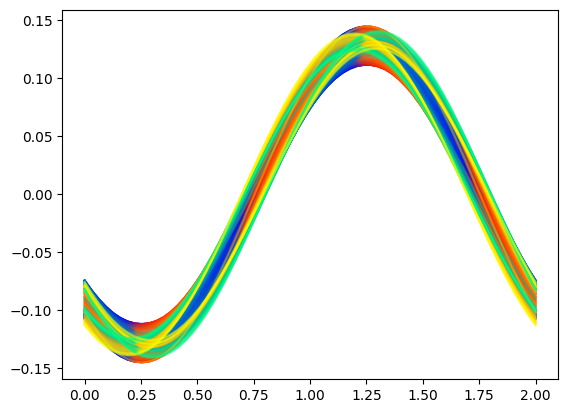

In [12]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots()
cm = mpl.colormaps['winter']
cm2 = mpl.colormaps['autumn']
norm = mpl.colors.Normalize()
_I  = list(range(64))
norm.autoscale(_I)
r = lresults
_x =np.linspace(0,2,64)
for i in _I[:]:
    ax.plot(_x,lresults[i],c=cm(norm(i)),alpha=0.2)
    ax.plot(_x,rresults[i],c=cm2(norm(i)),alpha=0.2)
    

#ax.set_xlim(0,10)
#ax.set_ylim(-0.15,-0.12)

In [16]:
rr = np.array([r[,:8] for r in results])

TypeError: list indices must be integers or slices, not tuple

In [18]:
results.shape

AttributeError: 'list' object has no attribute 'shape'

In [32]:
rr = np.array([[qq[-8:] for qq in q] for q in results])

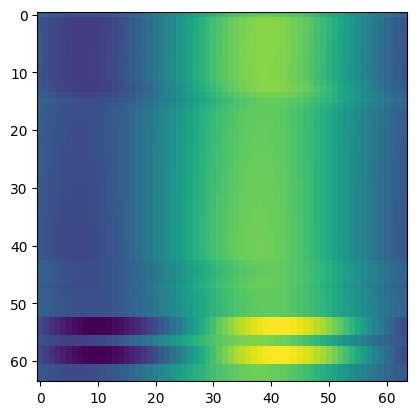

In [38]:
plt.imshow(rr[...,-6])

In [6]:


syst = syst_init()
_A =list(syst.envelope_model.band_model.function_dict.items())
Bx_sym = _A[0][0]
By_sym = _A[1][0]
from nqcpfem.functions import SymbolicFunction
print(_A)
def B_field_splitting(B_val):
   energies = []
   
   solver = PETScSolver(k=16,which='SM',sigma=0)
   syst = syst_init(B_val[0])
   for i,b in enumerate(B_val):
      LOGGER.info(i)
      
      syst.envelope_model.band_model.function_dict[Bx_sym] = SymbolicFunction( sympy.sympify(b/np.sqrt(2)),Bx_sym)
      syst.envelope_model.band_model.function_dict[By_sym] = SymbolicFunction(sympy.sympify(b/np.sqrt(2)),By_sym)
      
      S = system_update(7.040422e-22,7.367972e-22,7.375506e-22,syst=syst)
      SOL = solver.solve(S)
      energies.append(SOL[0])
   return energies


500000000000.0
[(B_{x}(x), <nqcpfem.functions.SymbolicFunction object at 0x7f9d73eb7dc0>), (B_{y}(x), <nqcpfem.functions.SymbolicFunction object at 0x7f9d73eb62c0>), (B_{z}(x), <nqcpfem.functions.SymbolicFunction object at 0x7f9d73abb280>), (V_{sys}(x), <nqcpfem.functions.SymbolicFunction object at 0x7f9d73f0eb90>), (\Delta_{sc}(x), <nqcpfem.functions.SymbolicFunction object at 0x7f9d7c1ac4c0>), (\mu(x), <nqcpfem.functions.SymbolicFunction object at 0x7f9d7c19f970>)]


In [7]:
B_vals = np.linspace(0,4,32)

splits = B_field_splitting(B_vals)

500000000000.0


INFO:nqcpfem.systems.dot_sc_dot:0
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
DEBUG:nqcpfem.fenics:gathering constants
DEBUG:nqcpfem.fenics:retrieving parameter and constant dicts
DEBUG:nqcpfem.fenics:updating values
DEBUG:nqcpfem.fenics:retireving energy scale
DEBUG:nqcpfem.fenics:computing energy_scale
DEBUG:nqcpfem.fenics:constructing array
DEBUG:nqcpfem.band_model:building numerical array
DEBUG:nqcpfem.band_model:constructing lambda map
DEBUG:nqcpfem.fenics:substituting
DEBUG:nqcpfem.fenics:casting back
DEBUG:nqcpfem.fenics:maximizing
DEBUG:nqcpfem.fenics:gathering constants complete
DEBUG:nqcpfem.fenics:assembling array
DEBUG:nqcpfem.solvers:solving problem:
DEBUG:nqcpfem.solvers: number of converged eigenvectors: 22


(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:1
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_316ed453ac8065db0967ebc3f37763168865fac8' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_316ed453

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:2
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_874eb27610039de7880defb4ef09fdf308abedd9' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_874eb276

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:3
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_fd6d2ad1ca080fc67cf8dd74d5d64cef68398b53' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_fd6d2ad1

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:4
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_406d8c0a83e91066075a2b5d9aab5004be30ed45' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_406d8c0a

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:5
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_33b5b1591df80067b3981f24ace5d5f8f64b0058' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_33b5b159

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:6
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_72af78dae8a0ace36b5e260feba21704dbb87147' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_72af78da

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:7
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_ffea2218e26f3cd7441683183a4455dd23961c4d' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_ffea2218

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:8
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_cca4369384e67151504df595a8b1a66716b8510b' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_cca43693

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:9
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_b0fee9dbddde63f66e21285a450ff1b428f07ab9' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_b0fee9db

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:10
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_56a4023a5976c6158da984e2689177adf01f11fb' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_56a4023

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:11
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_42d5ed012e58314f9acb906947e03c0a3aebecd1' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_42d5ed0

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:12
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_72632d2f6fee95edd97817299a0da9f6ebaaff17' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_72632d2

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:13
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_94267eeea8289092d94f8cef6a45e3bd9198d90a' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_94267ee

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:14
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_248d80b2019dc3a65c1a9e10a18d506409dd00e5' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_248d80b

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:15
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_265d46d0fd3488656594616a8bd9e079ffa25362' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_265d46d

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:16
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_3870042bba038d8b15c1de8e19895cb72ba00a91' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_3870042

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:17
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_b0d7566c616dc314777be797879256df11e365ca' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_b0d7566

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:18
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_cef25f064b4decf0b9bf8534d133e3f1e49ccdf3' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_cef25f0

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:19
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_10734219e04507651a0617c354d61dd9bc702716' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_1073421

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:20
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_2e9584b31f993f276d32c16fb027584f37f5ca5a' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_2e9584b

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:21
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_307dad19e1defeb601f96e88de92125815d4dd44' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_307dad1

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:22
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_7e614e3f4bfe6a932c6fe4f36f392ea6c56b6074' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_7e614e3

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:23
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_35fe7c413d21a0e8af1747b477d3173f32eb5b48' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_35fe7c4

(51408, 51408)


DEBUG:nqcpfem.solvers: number of converged eigenvectors: 18
INFO:nqcpfem.systems.dot_sc_dot:24
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_0bdcda48b6653097c4bff833edb2f987edd74487' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/mini

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:25
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_f2a2f18554bacb10c36294372207fe3b43a61a84' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_f2a2f18

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:26
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_eace3cab5ef0358446f8902a938d970e3fd499fc' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_eace3ca

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:27
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_f3cfba3b391f862fa132ea344da6d0c51653546b' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_f3cfba3

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:28
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_b0e0c3eea8445c92f40637c1861e62f7c44799f4' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_b0e0c3e

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:29
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_c42f8143d6a3d6ccbc95b5e298805451fdaf0e58' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_c42f814

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:30
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_fb89a9f6b4fb7b70f03603abad0ca4c3c61ab0df' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_fb89a9f

(51408, 51408)


INFO:nqcpfem.systems.dot_sc_dot:31
DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_82bf58db9add56b3eb8936707595e22b18227000' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_82bf58d

(51408, 51408)


In [ ]:
np.save('linBsplits.npy',splits)

In [26]:
def zero_pad_stack(arrs: list[np.ndarray],axis=0):
    assert all(len(a.shape)==len(arrs[0].shape) for a in arrs)
    max_shape = list(max((a.shape[i]) for a in arrs) for i in range(len(arrs[0].shape)))
    max_shape[axis:axis]=[len(arrs)]
    
    
    return_arr = np.zeros((max_shape),dtype=arrs[0].dtype) 
    for i,arr in enumerate(arrs):
        slice_list = [slice(0,n) for n in arr.shape]
        slice_list[axis:axis]=[i]
        return_arr[tuple(slice_list)] = arr 
        
    return return_arr
    
    
        
        
    
    
    

In [105]:
S = zero_pad_stack(splits)

In [106]:
from nqcpfem.band_model import covariant_sorting


In [107]:
from nqcpfem.envelope_function import sort_eigenvalues
SS = zero_pad_stack([sort_eigenvalues(s[:10]) for s in S])

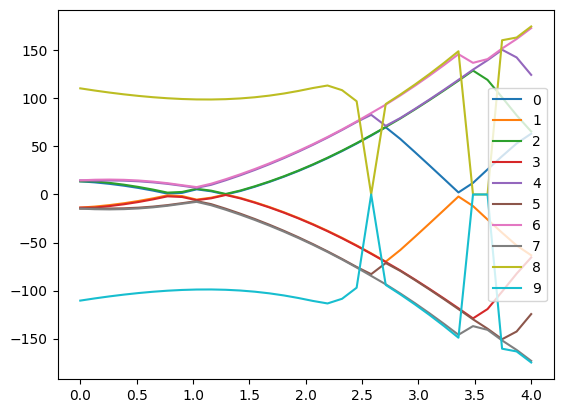

In [110]:
from matplotlib import pyplot as plt
plt.plot(B_vals,SS/E0,label=list(range(10)))
plt.legend()

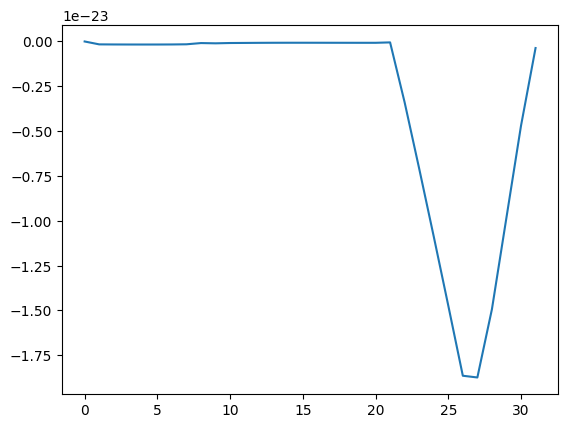

In [111]:
plt.plot(SS[:,0]-SS[:,2])

In [65]:
left,middle,right = S.__make_system_classes__()

In [18]:
sys = syst_init(B=2,aspect_ratio=1.6)
enf =system_update(7.040422e-22,4600*E0-270*E0,4600*E0-300*E0,syst=sys)
SOL = solver.solve(enf)

500000000000.0


DEBUG:nqcpfem.fenics:creating PETSc Matrix
DEBUG:nqcpfem.fenics:gathering bilinear_form
DEBUG:nqcpfem.fenics:computing ufl_form
DEBUG:nqcpfem.fenics:creating constants dict
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_71efecd493157dd1ce8ef2e01479dc93af633e7c' extension
INFO:root:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_71efecd493157dd1ce8ef2e01479dc93af633e7c.c

(51408, 51408)


DEBUG:nqcpfem.solvers: number of converged eigenvectors: 12


In [19]:
classification = sys.classify_states(SOL[1])

In [21]:
len(classification[sys.state_classes[1]])

0

In [5]:
classification

{StateClass: Left dot: [array([[[8.45841543e-20-2.33747087e-19j, 1.68613753e-19-2.16005226e-19j,
           3.00478029e-19-1.45661941e-19j, ...,
           1.99671799e-19-2.64706940e-20j, 2.61855824e-19-1.25733690e-19j,
           2.85362849e-20-1.00669771e-19j]],
  
         [[4.88581331e-20+9.19290504e-21j, 3.42927822e-19+2.78769430e-20j,
           2.57844838e-19-2.54311760e-19j, ...,
           1.90305925e-19-2.76849211e-19j, 7.50167016e-20-1.03496012e-19j,
           2.32479795e-19-1.08901733e-19j]],
  
         [[5.69760166e-20-1.25313450e-19j, 2.70961400e-19-2.54410996e-19j,
           2.14626864e-19-2.10298519e-19j, ...,
           5.58271381e-20-1.77705559e-19j, 1.75602556e-19+3.61817466e-20j,
           2.35366835e-19-1.60467472e-19j]],
  
         ...,
  
         [[2.07634123e-19-8.71939532e-20j, 1.82598656e-19-1.66972709e-19j,
           2.96224700e-19+3.93153995e-20j, ...,
           1.71027646e-19-1.35781087e-19j, 3.87486701e-19-1.44549663e-19j,
           1.31361986e-19

In [81]:
for _s in S.state_classes:
    _s.X_array = x_points 

In [ ]:
# build system with certain aspect ratio
# add magnetic field in x and y direction
# classify states
# compute spin gap for left and right dots respectively
